In [1]:
import numpy as np
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import glob
import time
import pandas as pd
from statistics import mean
import math
from scipy import constants
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter
from scipy import asarray as ar, exp, sqrt
from scipy.optimize import curve_fit
plt.rcParams["figure.figsize"] = (20,6)
import os
import sys
from scipy.optimize import curve_fit
import scipy.integrate as si
from scipy.integrate import quad
import shutil
import scienceplots 
plt.style.use(['science', 'notebook', 'grid'])

print (time.ctime())

Fri Sep 22 09:29:59 2023


In [2]:
import re

class EIT:
    def __init__(self, root, temp='50 C', probe_pwr='100 uW', span=(40/0.05)):
        self.root = root
        # make new folder if not exists
        self.npydir = (root+"npy_files")
        if not os.path.exists(self.npydir):
            os.mkdir(self.npydir)
        
        if not self.is_valid_format(temp, r'\d+ C$'):
            raise ValueError("Invalid Format. 'temp' should be a string composed of a number followed by ' C'")
        self.temp = temp
        
        if not self.is_valid_format(probe_pwr, r'\d+ uW$'):
            raise ValueError("Invalid Format. 'probe_pwr' should be a string composed of a number followed by ' uW'")
        self.probe_pwr = probe_pwr
        
        self.span = span
    
    def is_valid_format(self, val, pattern):
        return bool(re.match(pattern, val))
    
    def fit(self, data, file, func, current, fit_init_guess, fit_bounds):
            fig, ax = plt.subplots(figsize = (20,6), facecolor='w')

            best_vals, covar = curve_fit(func, data['Time(s)'], data['CH1(V)'],p0 = fit_init_guess, bounds=fit_bounds)
            
            print(best_vals)
#             print(best_vals,'\n', covar)

            ax.plot(data['Time(s)'], data['CH1(V)'], '-')

        #     ax.plot(data['Time(s)'], func(data['Time(s)'], *best_vals),'r-',label='Fit:B+A*e^(-C*(delta^2/(delta^2 + (delta^2/gamma+gamma_EIT)^2)) \n B=%5.4f, A=%5.4f, C=%5.4f, gamma=%5.6f, gamma_EIT=%5.6f, t_0=%5.6f,' % tuple(best_vals))
        #     ax.plot(data['Time(s)'], func(data['Time(s)'], *best_vals),'r-',label='Fit:B+A*(delta^2/(delta^2 + (delta^2/gamma+gamma_EIT)^2)) \n B=%5.4f, A=%5.4f, gamma=%5.6f, gamma_EIT=%5.6f, t_0=%5.6f,' % tuple(best_vals))
        #     ax.plot(data['Time(s)'], func(data['Time(s)'], *best_vals),'r-',label='Fit:B+A*e^(-C*(delta^2/(delta^2 + gamma_EIT)^2)) \n B=%5.4f, A=%5.4f, C=%5.4f, gamma_EIT=%5.6f, t_0=%5.6f,' % tuple(best_vals))
#             ax.plot(data['Time(s)'], func(data['Time(s)'], *best_vals),'r-',label='Fit:B+A*e^((-(delta_2)^2)/(2*gamma_EIT^2)) \n B=%5.4f, A=%5.4f, gamma_EIT=%5.6f, t_0=%5.6f,' % tuple(best_vals))
#             ax.plot(data['Time(s)'], func(data['Time(s)'], *best_vals),'r-',label='''Fit:A=%5.4f, OD=%5.4f,\n gamma=%5.4f, gamma_EIT=%5.6f,\n d=%5.6f''' % tuple(best_vals))
            ax.plot(data['Time(s)'], func(data['Time(s)'], *best_vals),'r-',label='''Fit:A=%5.4f, OD=%5.4f,\n gamma=%5.4f, gamma_EIT=%5.6f,\n d1=%5.6f, d2=%5.6f, d3=%5.6f''' % tuple(best_vals))

            ax.set_title(f'EIT Single Rail, Current {current} mA, Probe {self.probe_pwr}, Rb @ {self.temp}') 
            ax.set_xlabel('Freq. (MHz)', fontsize=12)
            ax.set_ylabel('Volts (V)', fontsize=12)
            plt.legend(loc='best')
            plt.savefig(file[:-4]+'_fit.png')

            np.save(self.npydir+f'/{file.rsplit("/",1)[-1][:-4]}_{current}mA_{self.temp[:-2]}C_best_vals.npy', best_vals)
            np.save(self.npydir+f'/{file.rsplit("/",1)[-1][:-4]}_{current}mA_{self.temp[:-2]}C_covar.npy', covar)
            return None

In [3]:
def detect_edges(df, column_name):
    edge_indices = {'rising': [], 'falling': []}
    prev_value = None
    
    for index, value in enumerate(df[column_name]):
        if prev_value is None:
            prev_value = value
            continue
        
        if value > prev_value+0.2:
            edge_indices['rising'].append(index)
        elif value < prev_value-0.2:
            edge_indices['falling'].append(index)
        
        prev_value = value
    
    return edge_indices

# Example usage:
# edge_indices = detect_edges(df, 'signal')
# rising_edge_indices = edge_indices['rising']
# falling_edge_indices = edge_indices['falling']

In [4]:
# def exp(t, a, b, T):
#     return a*(1-b*np.exp(-t**2/T**2))
# def inv_exp(t, a, b, T, t_o):
#     return a*(1-b*np.exp(-(t-t_o)/T))
# def asymptotic(t, a, b, t_o):
#     return a*(1-(b*t_o)/abs(t))
def gausslorentzian(B, A, C, delta, gamma, gamma_EIT, t_0):
    delta_2 = delta - t_0
    D = ((delta_2**2)/gamma)+gamma_EIT
    E = delta_2**2 + D**2
    return B+A*np.exp(-C*((delta_2**2)/E))

def lorentzian(B, A, delta, gamma, gamma_EIT, t_0):
    delta_2 = delta - t_0
    D = ((delta_2**2)/gamma)+gamma_EIT
    E = delta_2**2 + D**2
    return B+A*((delta_2**2)/E)

def gauss(B, A, C, delta, gamma_EIT, t_0):
    delta_2 = delta - t_0
    D = gamma_EIT
    E = delta_2**2 + D**2
    return B+A*np.exp(-C*((delta_2**2)/E))

def gauss2(B, A, delta, gamma_EIT, t_0):
    delta_2 = delta - t_0
    return B+A*np.exp((-(delta_2)**2)/(2*gamma_EIT**2))

# sigma = 400 + 80 + 205 #all units in MHz
# These are the free parameteres for the fitting of T: gamma, gamm_EIT, and OD
# gamma = 500 
# gamma_EIT = 10
# OD = 5
# a = (gamma**2)*(delta**2)
# b = (-delta*(sigma+delta))
# c = gamma*gamma_EIT
# f = ((a)/(a+(b+c)**2))

# Transmission of Probe without EIT
# x = gamma**2
# y = gamma**2 + (sigma + delta)**2
# T0 = np.exp(-OD*(x/y))

def eit_lorentz(delta, A, OD, gamma, gamma_EIT, d):
    delta_1 = delta-d
    a = (gamma**2)*(delta_1**2)
#     b = (-delta_1*(685+delta_1))
    b = (delta_1*(685-delta_1))
    c = gamma*gamma_EIT
    return A*np.exp(-OD*((a)/(a+(b+c)**2)))

# f = A*e^[-OD*(((gamma**2)*(delta**2))/((gamma**2)*(delta**2)+((-delta*(sigma+delta))+gamma*gamma_EIT)**2))]

def three_eit_lorentz(delta, A, OD, gamma, gamma_EIT, d1, d2, d3):
    delta_1 = delta-d1
    delta_2 = delta-d2
    delta_3 = delta-d3
    a1 = (gamma**2)*(delta_1**2)
    a2 = (gamma**2)*(delta_2**2)
    a3 = (gamma**2)*(delta_3**2)
#     b = (-delta_1*(685+delta_1))
    b1 = (delta_1*(685-delta_1))
    b2 = (delta_2*(685-delta_2))
    b3 = (delta_3*(685-delta_3))
    c = gamma*gamma_EIT
    return A*np.exp(-OD*((a1)/(a1+(b1+c)**2))) + A*np.exp(-OD*((a2)/(a2+(b2+c)**2))) + A*np.exp(-OD*((a3)/(a3+(b3+c)**2)))

In [5]:
# root = "/mnt/e/Google_Drive_Backup_E/Data/EIT_data_6_7_2023/" #root MSI
# root = "EIT_data_6_7_2023/" #root Lenovo
root = "data/EIT_data/9_19_2023_mag_lp_64/" #root Lenovo

In [59]:
# current = [*range(10,160,10)] #current in mA
# current = [0, 6.4, 9.9, 15.3,19.8,25.2,30.1,35.1,40.2,46.2,51.2,59.4,71.0,79.2,90.7,100.4] #9_19_2023_mag_lp_70
current = [0,6.2,9.7,16.4,21.4,26.2,31.3,36.7,41.7,46.5,51.1,56.0,67.7,76.2,86.4,95.9] #9_19_2023_mag_lp_64

In [61]:
current

[0,
 6.2,
 9.7,
 16.4,
 21.4,
 26.2,
 31.3,
 36.7,
 41.7,
 46.5,
 51.1,
 56.0,
 67.7,
 76.2,
 86.4,
 95.9]

In [7]:
nums = [*range(1,17)]

In [110]:
nums

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

In [111]:
len(current), len(nums)

(16, 16)

In [8]:
# eit_obj = EIT(root, temp='52', probe_pwr='53', span=(15/0.3)) #24_4
# eit_obj = EIT(root, temp='52', probe_pwr='53', span=(7.5/0.6)) #24_3
# eit_obj = EIT(root, temp='52', probe_pwr='53', span=(15/0.6)) #24_2
# eit_obj = EIT(root, temp='65 C', probe_pwr='465 uW', span=(25/1)) #Circular_9_8
# eit_obj = EIT(root, temp='65 C', probe_pwr='350 uW', span=(5/0.6)) #65C_CP_Lower_Range_9_14_2023
# eit_obj = EIT(root, temp='75 C', probe_pwr='350 uW', span=(5/0.6)) #75C_CP_Full_Range_9_14_2023
# eit_obj = EIT(root, temp='65 C', probe_pwr='350 uW', span=(5/0.6)) #LP_Mag_Field_9_14_2023
eit_obj = EIT(root, temp='64 C', probe_pwr='100 uW', span=(8/1.6)) #mag_lp_64_9_19_2023

data/EIT_data/75C_CP_Full_Range_9_14_2023/1.csv
Half-Period: 0.07199520000000001 s
Mon Sep 18 01:12:19 2023
[4.33345771e+00 3.62442370e-02 7.61796788e+02 9.19395091e-01
 2.97544825e+00]
data/EIT_data/75C_CP_Full_Range_9_14_2023/2.csv
Half-Period: 0.07199520000000001 s
Mon Sep 18 01:12:23 2023
[5.83178704e+00 2.72803196e-04 3.85988310e+00 1.25168548e-01
 2.50049692e+00]
data/EIT_data/75C_CP_Full_Range_9_14_2023/3.csv
Half-Period: 0.07199520000000001 s
Mon Sep 18 01:12:26 2023
[4.71148890e+00 4.10374252e-02 2.01621615e+03 5.21846080e-01
 2.82929617e+00]
data/EIT_data/75C_CP_Full_Range_9_14_2023/4.csv
Half-Period: 0.07199520000000001 s
Mon Sep 18 01:12:29 2023
[4.07933252e+00 3.51476533e-02 2.13498965e+03 5.93681210e-01
 2.96897162e+00]
data/EIT_data/75C_CP_Full_Range_9_14_2023/5.csv
Half-Period: 0.07199520000000001 s
Mon Sep 18 01:12:33 2023
[2.66294079e+00 5.51299635e-02 1.04558699e+03 5.54122133e-01
 2.91647549e+00]
data/EIT_data/75C_CP_Full_Range_9_14_2023/6.csv
Half-Period: 0.0719952

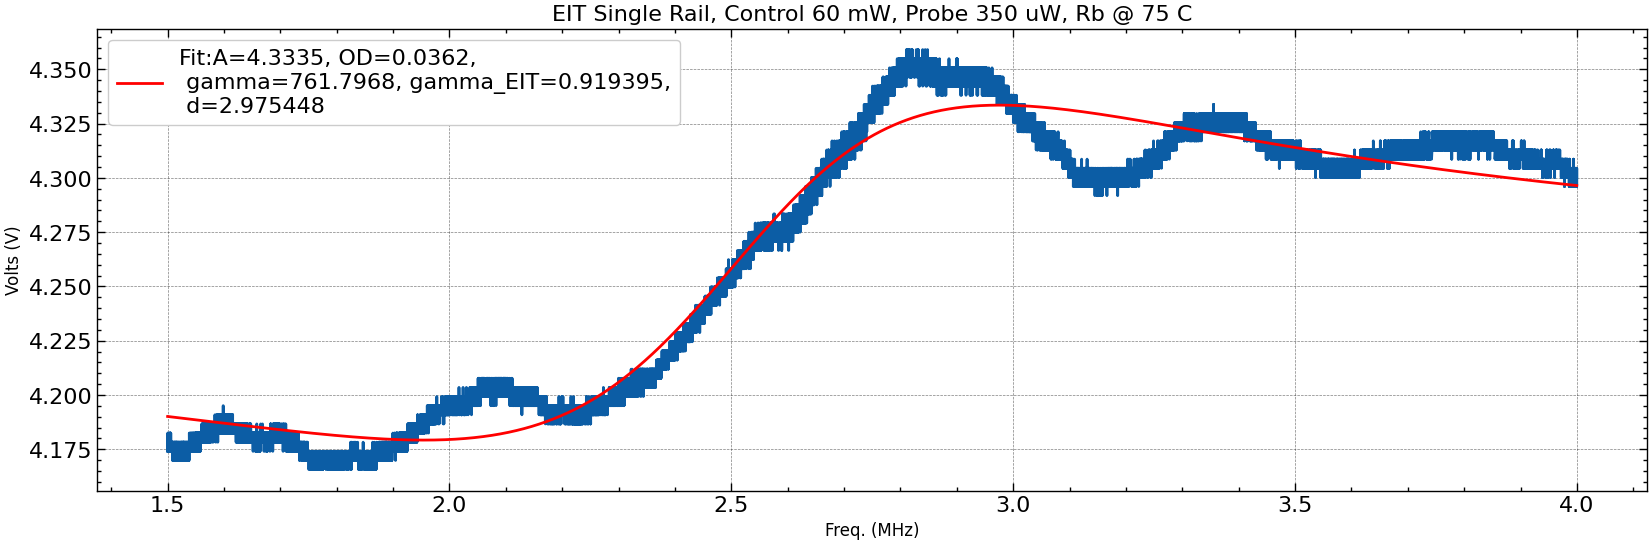

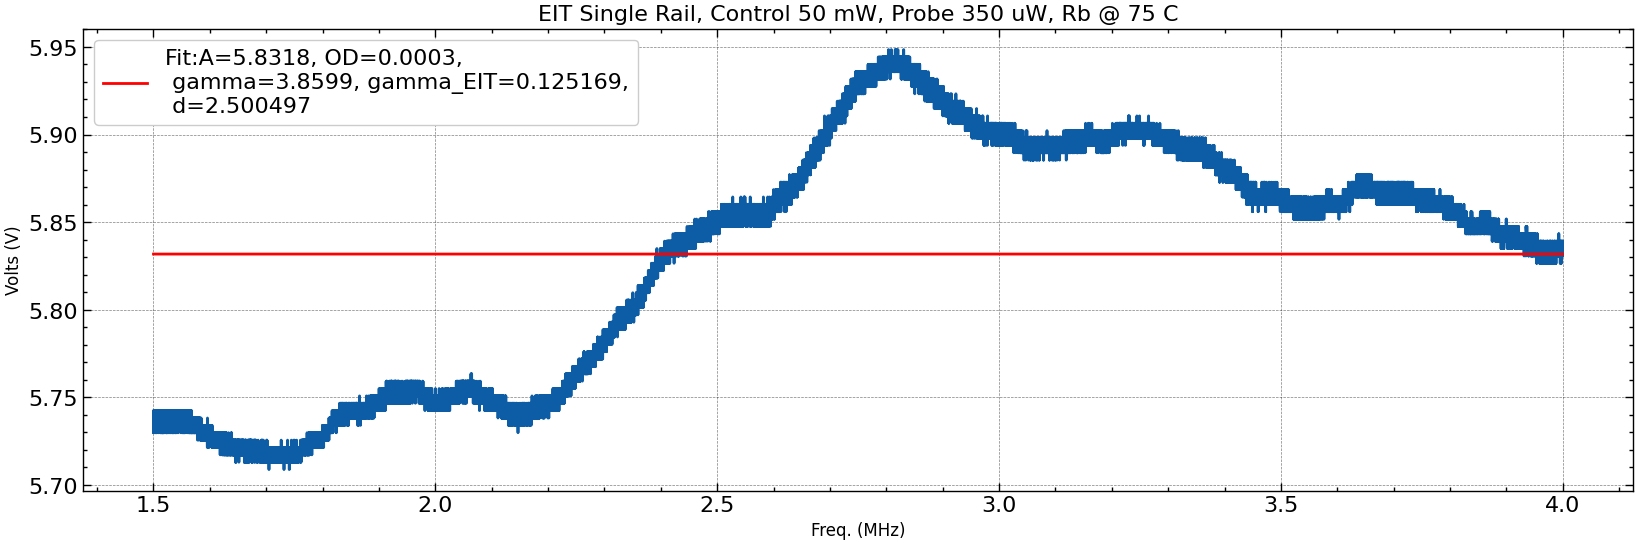

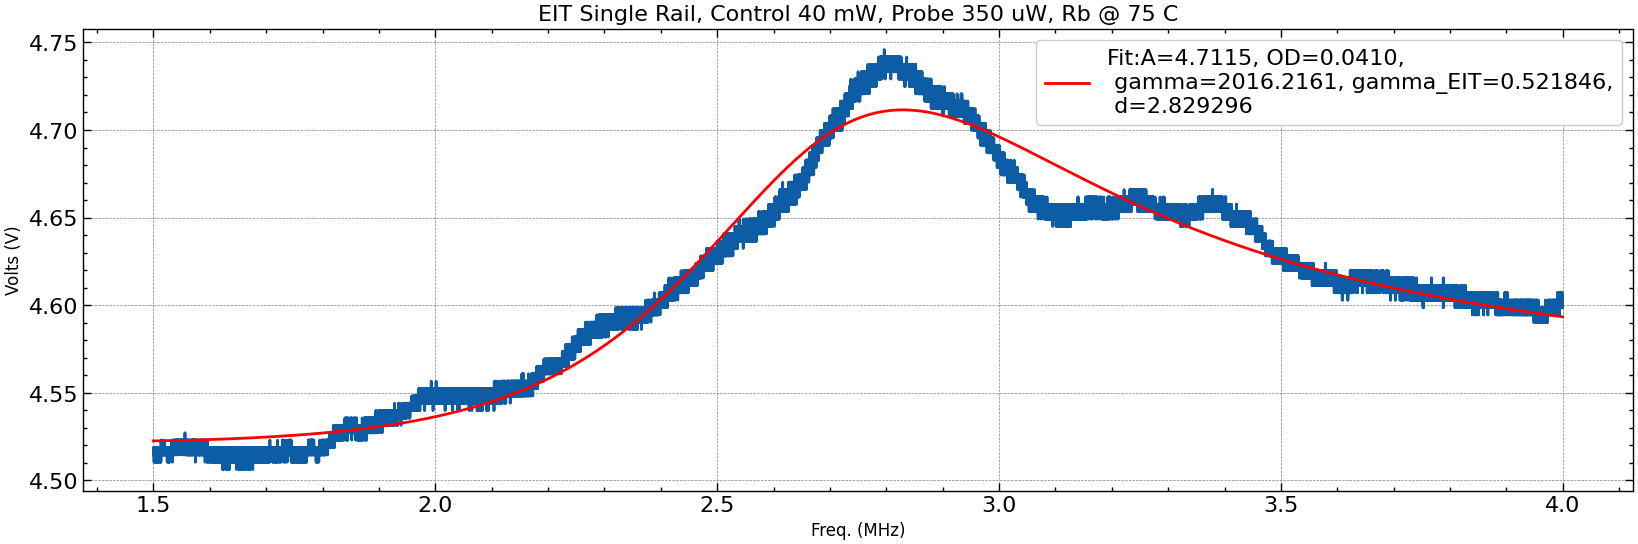

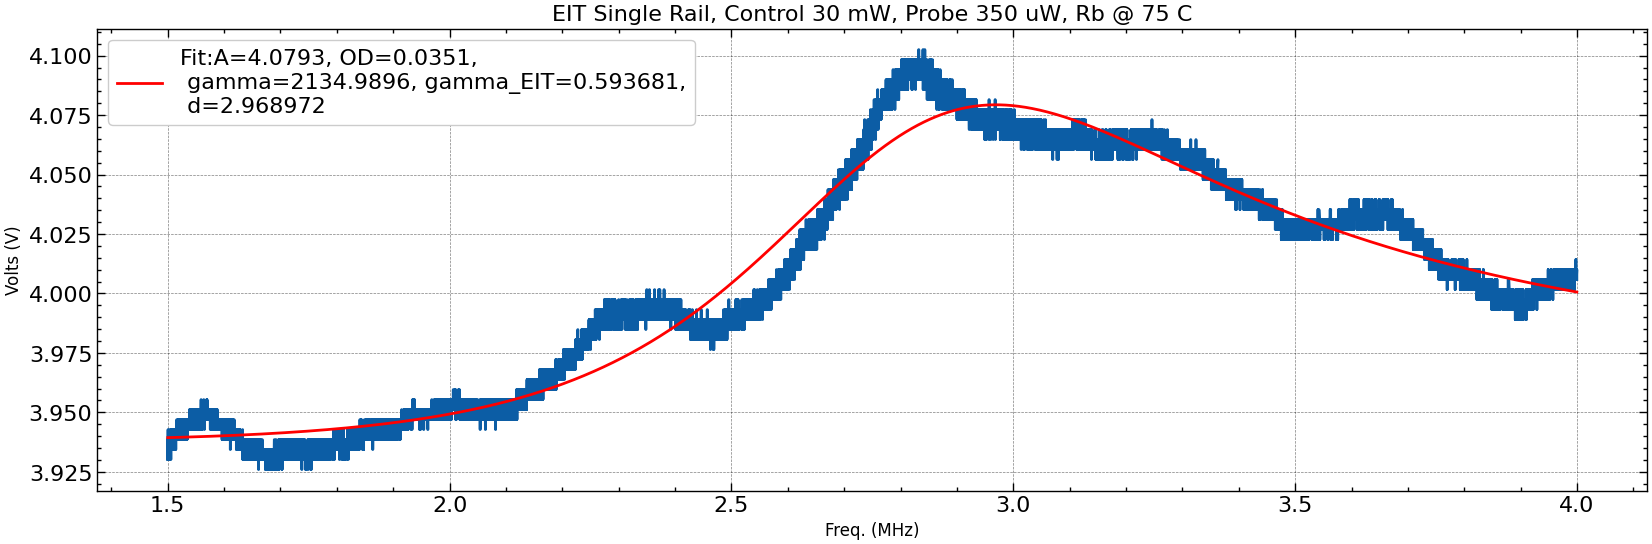

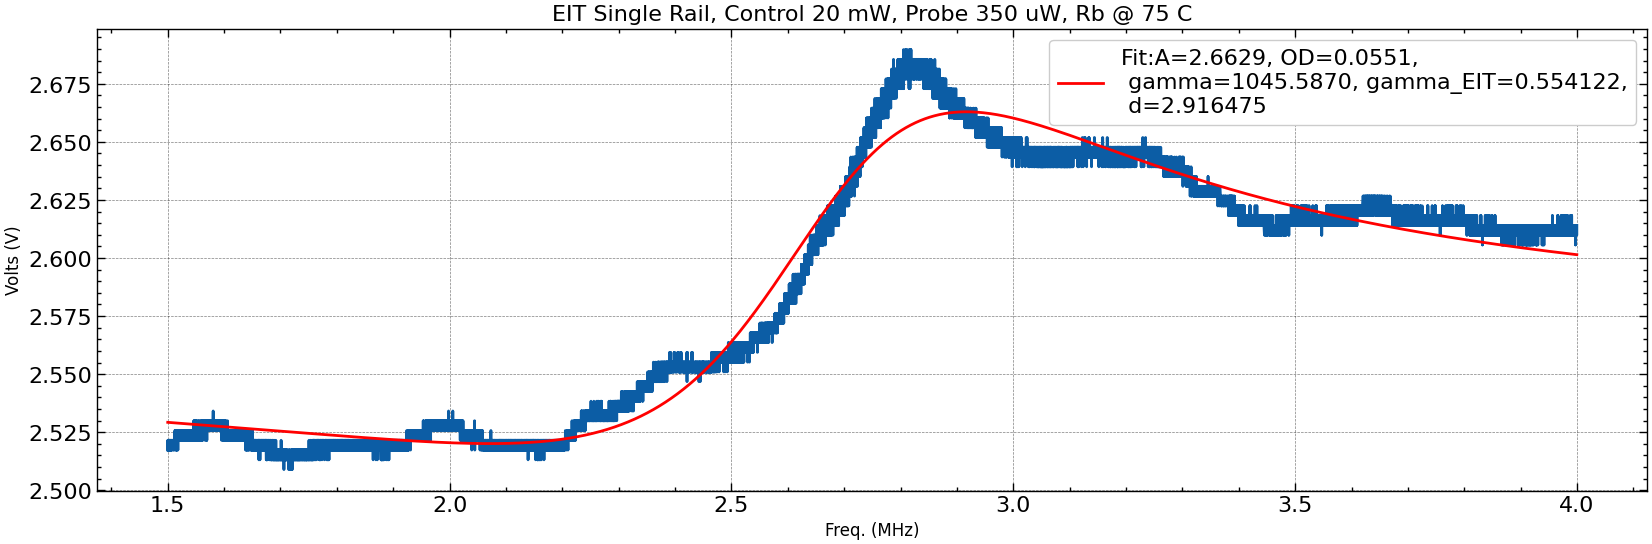

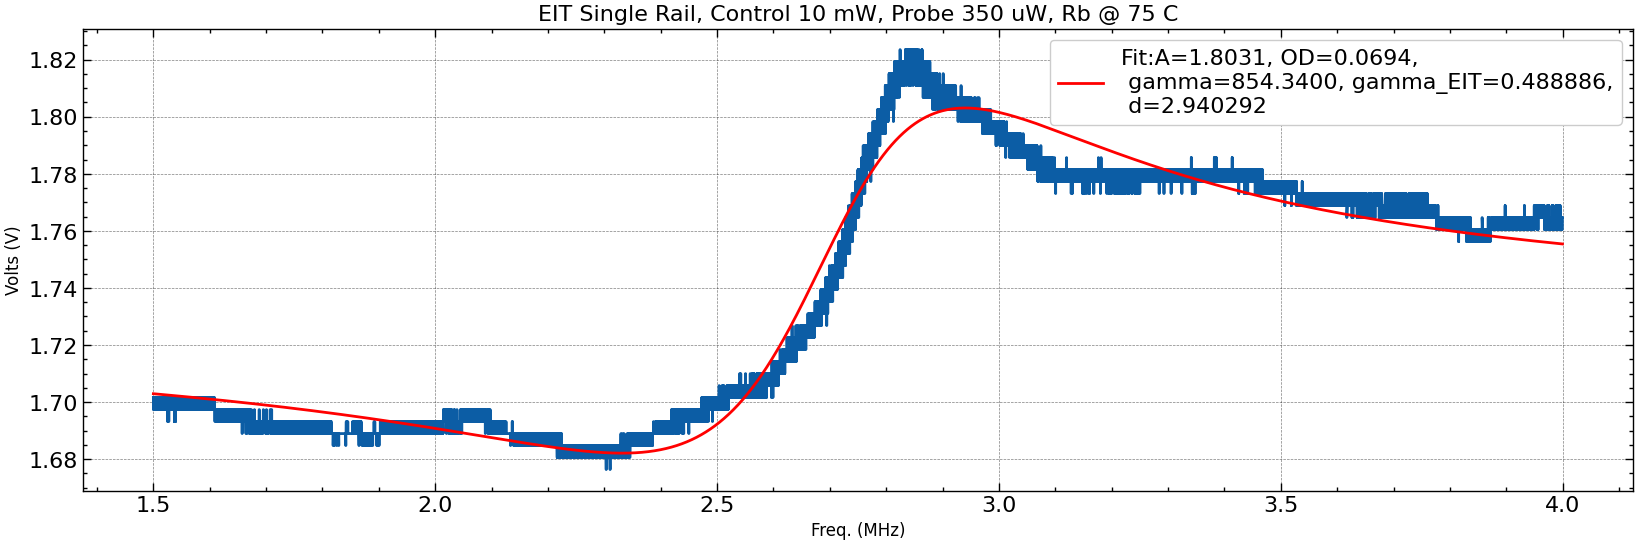

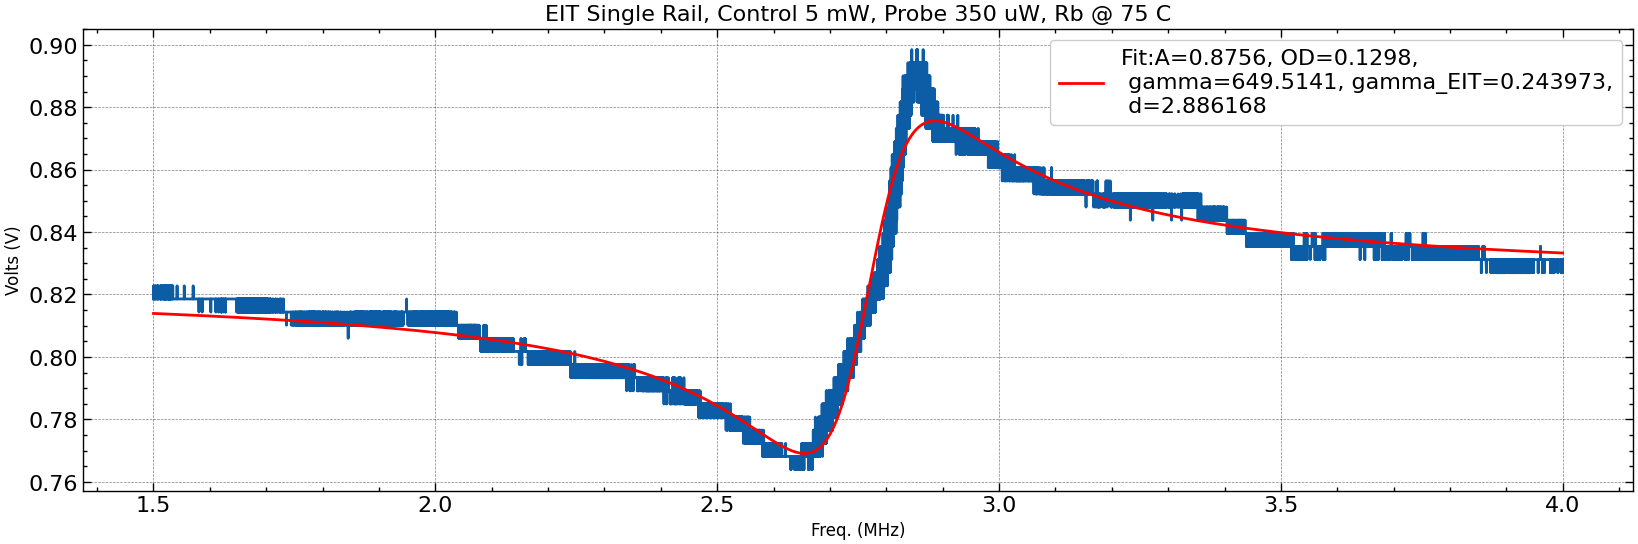

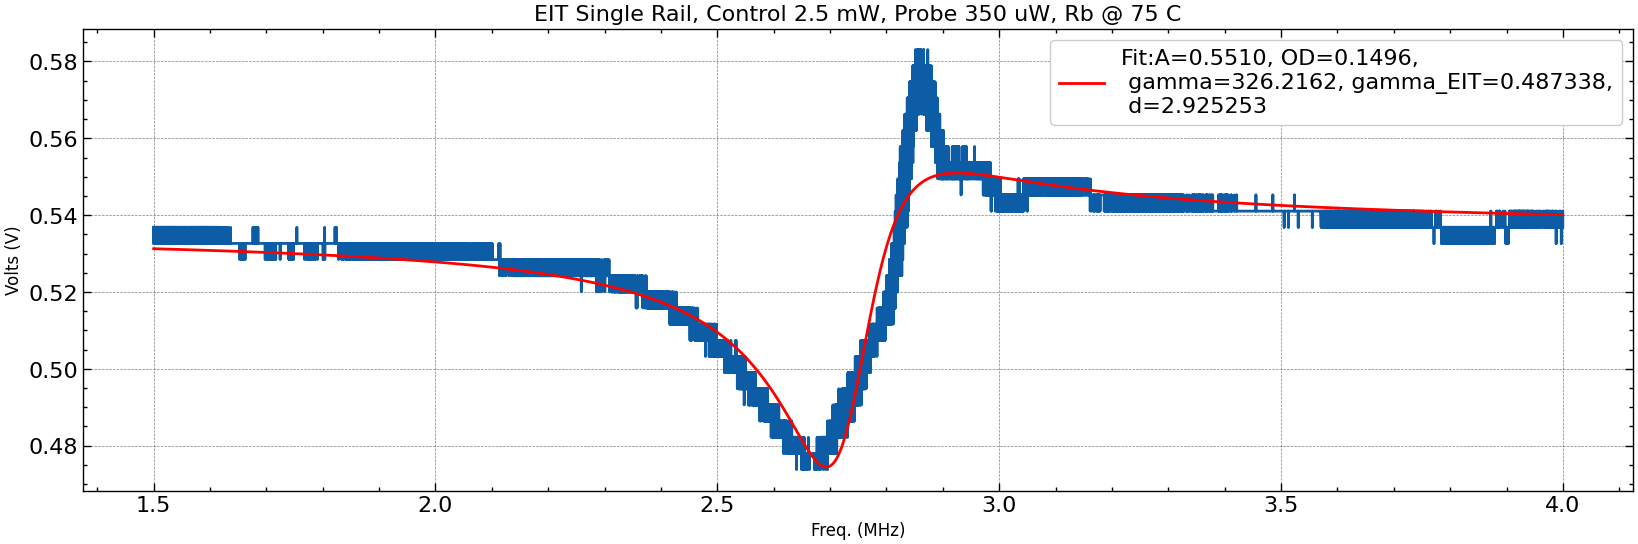

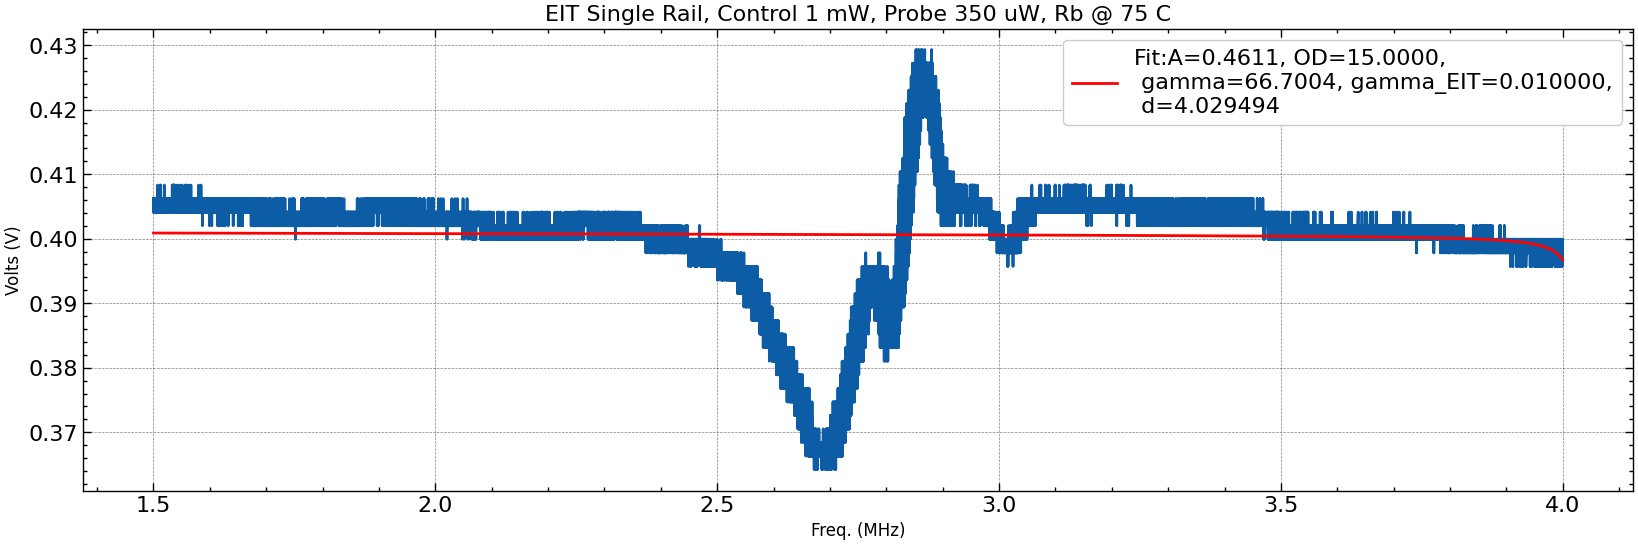

In [74]:

# nums = [25, 27, 28, 30, 31]
# # 31 dbm: 2.8 mW, 30 dbm: 2.1mW, 28 dbm: 1.1mW, 27 dbm: 792 uW, 25 dbm: 355 uW
# pwrs = [0.355, 0.792, 1.1, 2.1, 2.8]
i = 0 
for num in nums:
    file = (root+f"{str(num)}.csv")
    print(file)

    data = pd.read_csv(file)
    
    #filter data
#     #triangle ramp (ie. 8/11)
#     max_row = data[data['CH2(V)'] == data['CH2(V)'].max()]
#     # Extract the value from Column1 in the same row
#     time_max = max_row['Time(s)'].values[0]
#     # Find the row with the minimum value in Column2
#     min_row = data[data['CH2(V)'] == data['CH2(V)'].min()]
#     # Extract the value from Column1 in the same row
#     time_min = min_row['Time(s)'].values[0]
    # square wave sweep trigger
    edge_indices = detect_edges(data, 'CH2(V)')
    rising_value_at_index = data.loc[edge_indices['rising'][0], 'Time(s)']
    falling_value_at_index = data.loc[edge_indices['falling'][0], 'Time(s)']
    time_min = rising_value_at_index
    time_max = falling_value_at_index+(falling_value_at_index-rising_value_at_index)
#     time_min=falling_value_at_index+(falling_value_at_index-rising_value_at_index)
#     time_max=time_min+(time_min-rising_value_at_index)
    data = data[(data['Time(s)']>time_min) & (data['Time(s)']<time_max)]
    data['Time(s)'] = data['Time(s)']*eit_obj.span #convert time to frequency with sweep params
    data['CH1(V)'] = data['CH1(V)']+0.15 # add postive offset to y data
    # flip to postive x axis & make positive slope for fitting func aka y = f(-x)
    data['Time(s)'] = -data['Time(s)']
    # offset from zero
    data['Time(s)'] = data['Time(s)'] - data['Time(s)'].min()
    
    print(f'''Half-Period: {((falling_value_at_index+(falling_value_at_index-rising_value_at_index))
    -rising_value_at_index)*(1/eit_obj.span)} s''')
    print(time.ctime())

#     print(data)
#     (B, A, C, delta, gamma, gamma_EIT)
#     fitInitGuess = [0.06, 0.8, 10*10**(-5), 1*10**(-4)]
#     fitBounds=((0,0.5,0,0*10**-4),(5.0, 0.9, 0.001, 1*10**(-3)))
    # gauss2(B, A, gamma_EIT, t_0)
    # 4MHz = 1s
#     fitInitGuess = [1.11, 0.1, 0.25, 0.23]
#     fitInitGuess = [685, 500, 10]
#     fitBounds=((650, 300, 0),(700, 600, 20))
#     fitInitGuess = [685, 500,0.001]
#     fitBounds=((650, 300, 0),(700, 600, 0.010))
#     fitInitGuess = [1,1, 400, 1, 0]
#     fitBounds = ((0, 0.1, 200, 0.1, -10), (1, 5, 800, 10, 10)) #EIT_data_8_11_2023
#     fitInitGuess = [1,1, 400, 1, 0]
#     fitBounds = ((0, 0.1, 200, 0.1, -10), (1, 5, 800, 10, 10)) #EIT_data_8_11_2023
#     fitInitGuess = [1,1, 400, 0.01, 1075]
#     fitBounds = ((0, 0.1, 200, 0, 950), (1, 5, 800, 100, 1200)) #EIT_data_8_17_2023
#     fitInitGuess = [1,1, 400, 0.01, 220]
#     fitBounds = ((0, 0.1, 200, 0, 0), (1, 5, 800, 100, 500)) #EIT_data_8_18_2023
#     fitInitGuess = [1,1, 400, 0.01, 7.5]
# #     fitBounds = ((0, 0.1, 0, 0, 0), (1, 15, 800, 100, 10)) #24_2
#     fitInitGuess = [1,1, 400, 0.01, 22]
#     fitBounds = ((0, 0.1, 0, 0.01, 15), (1, 15, 10000, 100, 30)) #24_2 2nd peak
#     fitInitGuess = [1,1, 400, 0.01, 19]
#     fitBounds = ((0, 0.1, 0, 0, 0), (1, 15, 800, 100, 20)) #24_3
#     fitInitGuess = [1,1, 400, 0.01, 26]
#     fitBounds = ((0, 0.1, 0, 0, 22), (1, 15, 10000, 100, 30)) #24_3 2nd peak
#     fitInitGuess = [1,1, 400, 0.01, 98]
#     fitBounds = ((0, 0.1, 0, 0, 90), (1, 15, 800, 100, 105)) #24_4
#     fitInitGuess = [1,1, 400, 0.01, 112]
#     fitBounds = ((0, 0.1, 0, 0, 106), (1, 15, 800, 100, 120)) #2_24 2nd peak
#     fitInitGuess = [1,1, 400, 0.01, 2.5]
#     fitBounds = ((0, 0, 0, 0.01, 0), (10, 15, 10000, 100, 5)) #65C_CP_Lower_Range_9_14_2023
    data = data[(data['Time(s)']>1.5) & (data['Time(s)']<4)]
    fitInitGuess = [1,1, 400, 0.01, 2.5]
    fitBounds = ((0, 0, 0, 0.01, 0), (10, 15, 10000, 100, 5))
    eit_obj.fit(data, file, eit_lorentz, pwrs[i], fitInitGuess, fitBounds)
    i = i+1

data/EIT_data/9_19_2023_mag_lp_64/1.csv
data/EIT_data/9_19_2023_mag_lp_64/2.csv
data/EIT_data/9_19_2023_mag_lp_64/3.csv
data/EIT_data/9_19_2023_mag_lp_64/4.csv
data/EIT_data/9_19_2023_mag_lp_64/5.csv
data/EIT_data/9_19_2023_mag_lp_64/6.csv
data/EIT_data/9_19_2023_mag_lp_64/7.csv
data/EIT_data/9_19_2023_mag_lp_64/8.csv
data/EIT_data/9_19_2023_mag_lp_64/9.csv
data/EIT_data/9_19_2023_mag_lp_64/10.csv
data/EIT_data/9_19_2023_mag_lp_64/11.csv
data/EIT_data/9_19_2023_mag_lp_64/12.csv
data/EIT_data/9_19_2023_mag_lp_64/13.csv
data/EIT_data/9_19_2023_mag_lp_64/14.csv
data/EIT_data/9_19_2023_mag_lp_64/15.csv
data/EIT_data/9_19_2023_mag_lp_64/16.csv


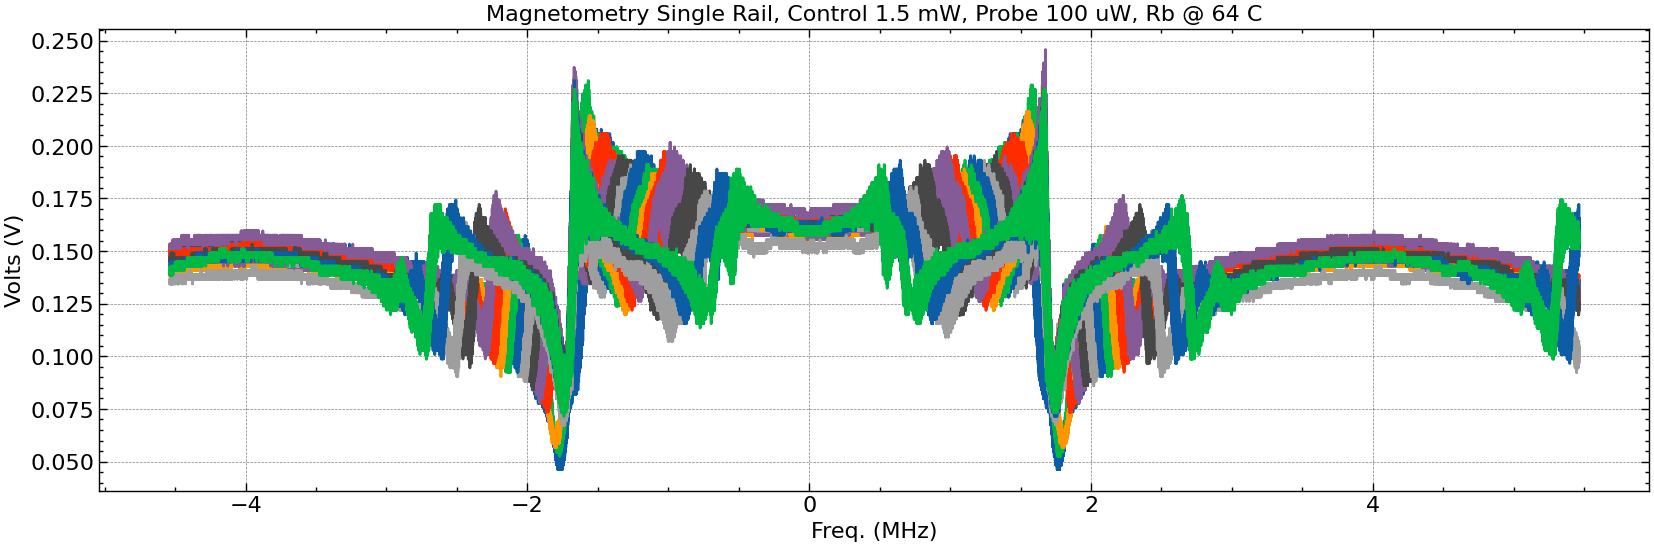

In [54]:
fig, ax = plt.subplots(figsize = (20,6), facecolor='w')
for num in nums:
    file = (root+f"{str(num)}.csv")
    print(file)
    data = pd.read_csv(file)
    
    #filter data
#     max_row = data[data['CH2(V)'] == data['CH2(V)'].max()]
#     # Extract the value from Column1 in the same row
#     time_max = max_row['Time(s)'].values[0]
#     # Find the row with the minimum value in Column2
#     min_row = data[data['CH2(V)'] == data['CH2(V)'].min()]
#     # Extract the value from Column1 in the same row
#     time_min = min_row['Time(s)'].values[0]
#     data = data[(data['Time(s)']>time_min) & (data['Time(s)']<time_max)]
    data['Time(s)'] = data['Time(s)']*eit_obj.span
    
    ax.plot(data['Time(s)'], data['CH1(V)'], '-', label=str(current[num-1]))
    # ax.plot(data['Time(s)'], data['CH2(V)'], '-'
    ax.set_title(f'Magnetometry Single Rail, Control 1.5 mW, Probe {eit_obj.probe_pwr}, Rb @ {eit_obj.temp}') 
    ax.set_xlabel('Freq. (MHz)', fontsize=16)
    ax.set_ylabel('Volts (V)', fontsize=16)
    ax.grid(True)
#     ax.legend(loc='best')
plt.savefig(root+'all_traces_fullspan.png')

data/EIT_data/9_19_2023_mag_lp_64/1.csv
data/EIT_data/9_19_2023_mag_lp_64/2.csv
data/EIT_data/9_19_2023_mag_lp_64/3.csv
data/EIT_data/9_19_2023_mag_lp_64/4.csv
data/EIT_data/9_19_2023_mag_lp_64/5.csv
data/EIT_data/9_19_2023_mag_lp_64/6.csv
data/EIT_data/9_19_2023_mag_lp_64/7.csv
data/EIT_data/9_19_2023_mag_lp_64/8.csv
data/EIT_data/9_19_2023_mag_lp_64/9.csv
data/EIT_data/9_19_2023_mag_lp_64/10.csv
data/EIT_data/9_19_2023_mag_lp_64/11.csv
data/EIT_data/9_19_2023_mag_lp_64/12.csv
data/EIT_data/9_19_2023_mag_lp_64/13.csv
data/EIT_data/9_19_2023_mag_lp_64/14.csv
data/EIT_data/9_19_2023_mag_lp_64/15.csv
data/EIT_data/9_19_2023_mag_lp_64/16.csv


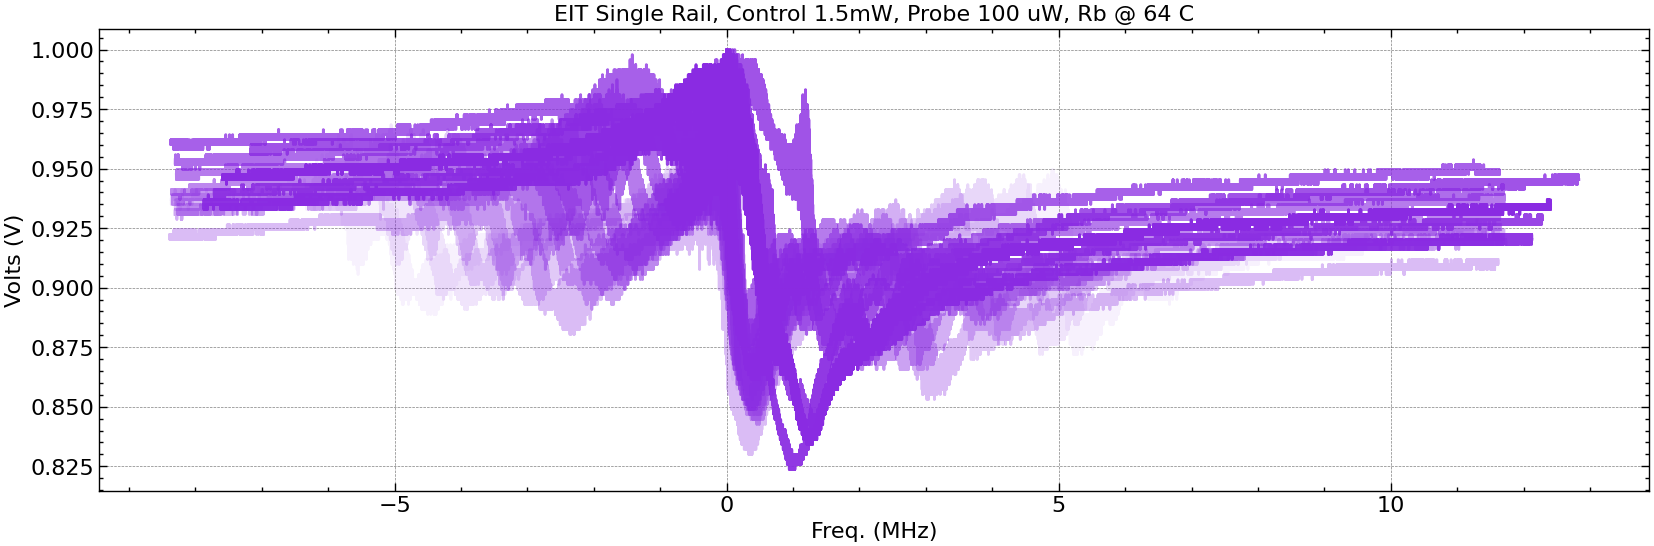

In [118]:
fig, ax = plt.subplots(figsize = (20,6), facecolor='w')
a=1
for num in nums:
    file = (root+f"{str(num)}.csv")
    print(file)
    data = pd.read_csv(file)
    
    #filter data
#     #triangle trigger
#     max_row = data[data['CH2(V)'] == data['CH2(V)'].max()]
#     # Extract the value from Column1 in the same row
#     time_max = max_row['Time(s)'].values[0]
#     # Find the row with the minimum value in Column2
#     min_row = data[data['CH2(V)'] == data['CH2(V)'].min()]
#     # Extract the value from Column1 in the same row
#     time_min = min_row['Time(s)'].values[0]
    
    #square trigger
    edge_indices = detect_edges(data, 'CH2(V)')
    rising_value_at_index = data.loc[edge_indices['rising'][0], 'Time(s)']
    falling_value_at_index = data.loc[edge_indices['falling'][0], 'Time(s)']
    time_min = rising_value_at_index
    time_max = falling_value_at_index+(falling_value_at_index-rising_value_at_index)
#     time_min=falling_value_at_index+(falling_value_at_index-rising_value_at_index)
#     time_max=time_min+(time_min-rising_value_at_index)
    
    
    data = data[(data['Time(s)']>time_min) & (data['Time(s)']<time_max)]
    data['Time(s)'] = data['Time(s)']*eit_obj.span
    midpoint = data['CH1(V)'].max() - data['CH1(V)'].min() / 2
#     closest_row = df.iloc[(df['Y'] - average_y).abs().argsort()[:1]]
    freqmidpoint_row = data[data['CH1(V)'] == data['CH1(V)'].max()]
    freqmidpoint = freqmidpoint_row['Time(s)'].values[0]
    data['Time(s)'] = data['Time(s)']-(freqmidpoint)
    
    data['CH1(V)'] = data['CH1(V)']-(data['CH1(V)'].max()-1) 
    
    
    ax.plot(data['Time(s)']*eit_obj.span, data['CH1(V)'], '-',color="blueviolet", alpha=a)
    # ax.plot(data['Time(s)'], data['CH2(V)'], '-'
    ax.set_title(f'EIT Single Rail, Control 1.5mW, Probe {eit_obj.probe_pwr}, Rb @ {eit_obj.temp}') 
    ax.set_xlabel('Freq. (MHz)', fontsize=16)
    ax.set_ylabel('Volts (V)', fontsize=16)
    ax.grid(True)
    a = a - (1/16)
plt.savefig(root+'all_traces_centered.png')

data/EIT_data/mag_lp_64_9_19_2023/5.csv
Wed Sep 20 13:20:55 2023
Rising edge indices: [226859, 226860]
Rising edge x value: -1.9999999999999998e-05
Falling edge indices: [326860]
Falling edge x value: 2.0
Half-Period: 0.800008 s


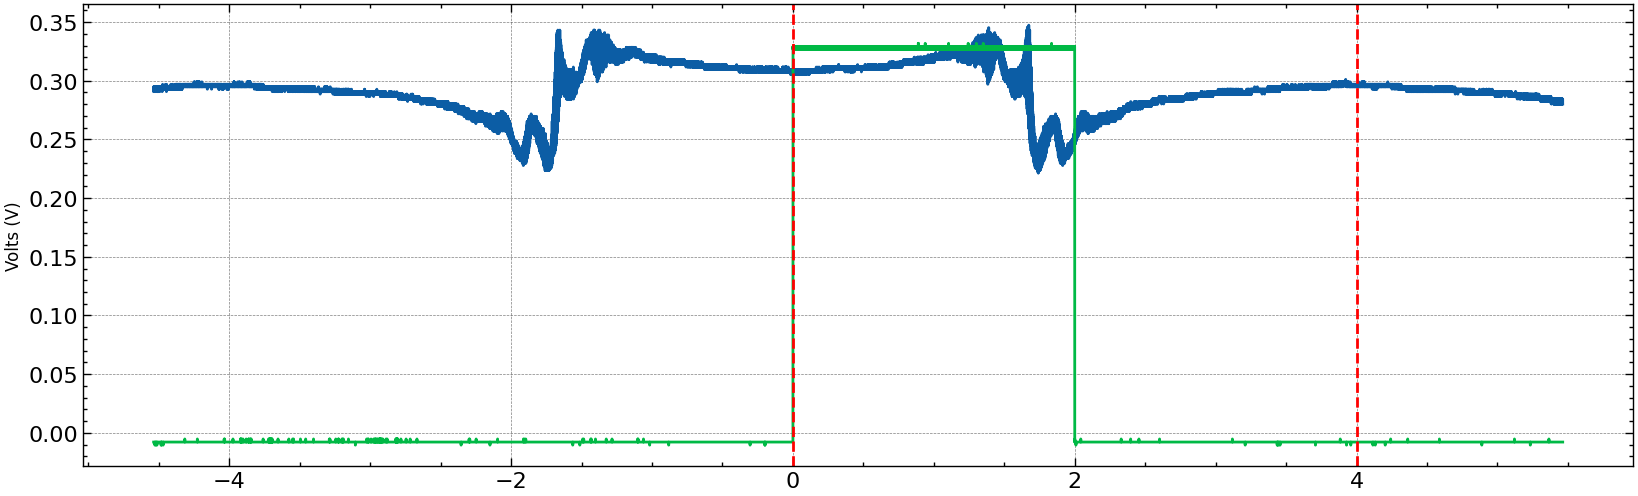

In [81]:
file = (root+f"{5}.csv")
print(file)

data = pd.read_csv(file)

#filter data
# data = data[data['Time(s)']<-0.03]
# data['Time(s)'] = data['Time(s)']+(0-data['Time(s)'].min())
# data['Time(s)'] = data['Time(s)']*(40/0.05)


data['Time(s)'] = data['Time(s)']*eit_obj.span

data['CH1(V)'] = data['CH1(V)']+0.15

print(time.ctime())
# print(data)
fig, ax = plt.subplots(figsize = (20,6), facecolor='w')

ax.plot(data['Time(s)'], data['CH1(V)'], '-')
ax.plot(data['Time(s)'], data['CH2(V)']/10, '-')


edge_indices = detect_edges(data, 'CH2(V)')

print("Rising edge indices:", edge_indices['rising'])

rising_value_at_index = data.loc[edge_indices['rising'][0], 'Time(s)']
print(f'Rising edge x value: {rising_value_at_index}')


print("Falling edge indices:", edge_indices['falling'])

falling_value_at_index = data.loc[edge_indices['falling'][0], 'Time(s)']
print(f'Falling edge x value: {falling_value_at_index}')

time_min=rising_value_at_index
time_max=falling_value_at_index+(falling_value_at_index-rising_value_at_index)
# time_min=falling_value_at_index+(falling_value_at_index-rising_value_at_index)
# time_max=time_min+(time_min-rising_value_at_index)

ax.axvline(x=time_min, color='r', linestyle='--', label='Falling Edge')
ax.axvline(x=time_max, color='r', linestyle='--', label='Falling Edge')
# ax.axvline(x=rising_value_at_index, color='r', linestyle='--', label='Rising Edge')
# ax.axvline(x=falling_value_at_index, color='r', linestyle='--', label='Falling Edge')
# ax.axvline(x=falling_value_at_index+(falling_value_at_index-rising_value_at_index), color='r', linestyle='--', label='Falling Edge + time high')


# ax.set_title('EIT Single Rail, Control 2.1 mW, Probe 46 uW, Rb @ 55 C') 
# ax.set_xlabel('Time (s)', fontsize=12)
ax.set_ylabel('Volts (V)', fontsize=12)
ax.grid(True)

print(f'Half-Period: {((falling_value_at_index+(falling_value_at_index-rising_value_at_index))-rising_value_at_index)*(1/eit_obj.span)} s')

data/EIT_data/9_19_2023_mag_lp_64/1.csv
Fri Sep 22 06:11:59 2023
Fri Sep 22 06:11:59 2023
[1.15975658e-01 6.28654288e-01 3.80591087e+02 4.03228411e-01
 2.51663852e+00 2.41203115e+00 2.54730428e+00]


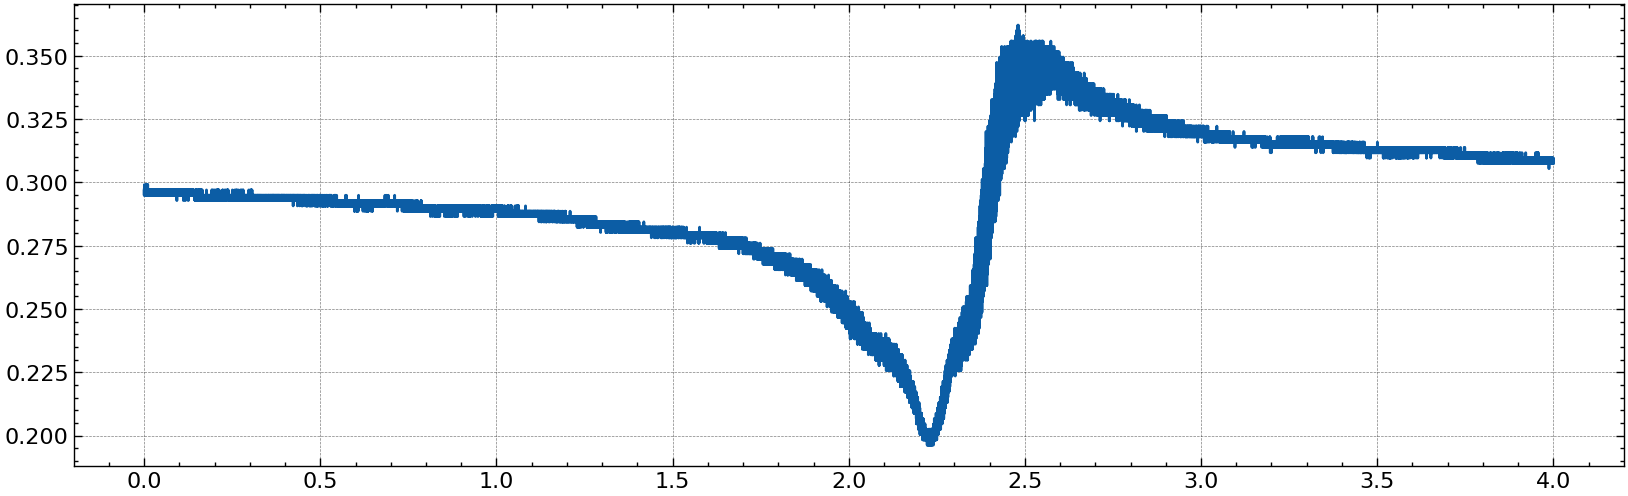

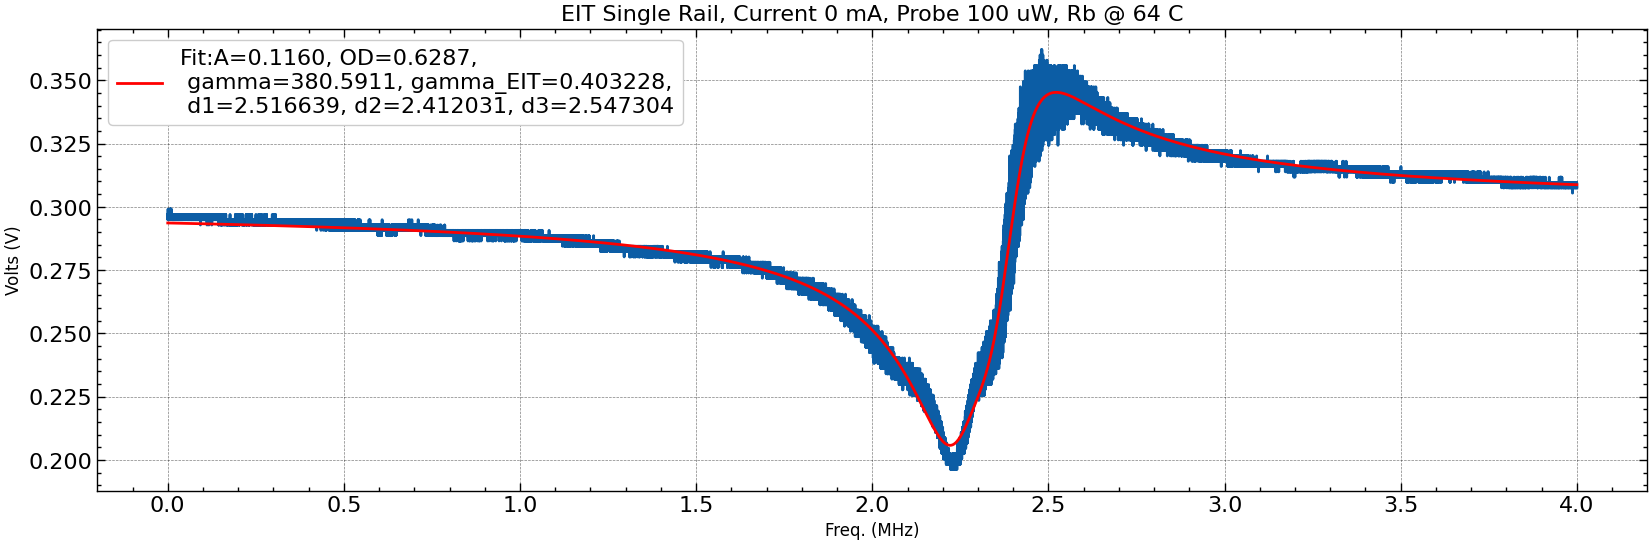

In [49]:
num = 1
file = (eit_obj.root+f"{num}.csv")
print(file)
data = pd.read_csv(file)

#filter data
# #Triangle wave
# # Find the row with the minimum value in Column2
# min_row = data[data['CH2(V)'] == data['CH2(V)'].min()]
# # Extract the value from Column1 in the same row
# time_min = min_row['Time(s)'].values[0]
# max_row = data[data['CH2(V)'] == data['CH2(V)'].max()]
# # Extract the value from Column1 in the same row
# time_max = max_row['Time(s)'].values[0]
#Square wave
edge_indices = detect_edges(data, 'CH2(V)')
rising_value_at_index = data.loc[edge_indices['rising'][0], 'Time(s)']
falling_value_at_index = data.loc[edge_indices['falling'][0], 'Time(s)']
time_min = rising_value_at_index
time_max = falling_value_at_index+(falling_value_at_index-rising_value_at_index)
# time_min=falling_value_at_index+(falling_value_at_index-rising_value_at_index)
# time_max=time_min+(time_min-rising_value_at_index)

# time_min = time_min+10
# time_max = time_max-10

data = data[(data['Time(s)']>time_min) & (data['Time(s)']<time_max)]
# data = data[data['Time(s)']<-0.03]
# data['Time(s)'] = data['Time(s)']+(0-data['Time(s)'].min())
# data['Time(s)'] = data['Time(s)']*(100000)
# data['Time(s)'] = data['Time(s)']*(40/0.05)

print(time.ctime())



data['Time(s)'] = data['Time(s)']*eit_obj.span

data['CH1(V)'] = data['CH1(V)']+0.15
# make positive
# data['Time(s)'] = data['Time(s)'] + (0 - data['Time(s)'].min())
# flip to postive x axis & make positive slope for fitting func 
data['Time(s)'] = -data['Time(s)']
# offset from zero
data['Time(s)'] = data['Time(s)'] - data['Time(s)'].min()

# data = data[(data['Time(s)']>1.5) & (data['Time(s)']<3.35)]


print(time.ctime())
# print(data)

fig, ax = plt.subplots(figsize = (20,6), facecolor='w')
ax.plot(data['Time(s)'], data['CH1(V)'], '-')
# ax.plot(data['Time(s)'], data['CH2(V)']/10, '-')
# def eit_lorentz(delta, sigma, gamma, gamma_EIT):
#     a = (gamma**2)*(delta**2)
#     b = (-delta*(sigma+delta))
#     c = gamma*gamma_EIT
#     return np.exp(((a)/(a+(b+c)**2)))

# fitInitGuess = [1,1, 400, 0.01, 2.5]

# fitBounds = ((0, 0, 0, 0.01, 0), (10, 15, 10000, 100, 5))


# def three_eit_lorentz2(delta, A, OD, gamma, gamma_EIT, d1, d2, d3, d4, d5):
#     delta_1 = delta-d1
#     delta_2 = delta-d2
#     delta_3 = delta-d3
#     delta_4 = delta-d4
#     delta_5= delta-d5
#     a1 = (gamma**2)*(delta_1**2)
#     a2 = (gamma**2)*(delta_2**2)
#     a3 = (gamma**2)*(delta_3**2)
#     a4 = (gamma**2)*(delta_4**2)
#     a5 = (gamma**2)*(delta_5**2)
# #     b = (-delta_1*(685+delta_1))
#     b1 = (delta_1*(685-delta_1))
#     b2 = (delta_2*(685-delta_2))
#     b3 = (delta_3*(685-delta_3))
#     b4 = (delta_4*(685-delta_4))
#     b5 = (delta_5*(685-delta_5))
#     c = gamma*gamma_EIT
#     return A*np.exp(-OD*((a1)/(a1+(b1+c)**2))) + A*np.exp(-OD*((a2)/(a2+(b2+c)**2))) + A*np.exp(-OD*((a3)/(a3+(b3+c)**2))) + + A*np.exp(-OD*((a4)/(a4+(b4+c)**2))) + + A*np.exp(-OD*((a5)/(a5+(b5+c)**2)))

# fitInitGuess = [1,1, 400, 0.01, 1.4,2.3,3.5,1.1,3.3]

# fitBounds = ((0, 0, 0, 0.01, 0, 0, 0,0,0), (10, 15, 10000, 100, 5, 5, 5,5,5))
fitInitGuess = [1,1, 400, 0.01, 2.35,2.35,2.35]

fitBounds = ((0, 0, 0, 0.01, 0, 0, 0), (10, 15, 10000, 100, 5, 5, 5))

eit_obj.fit(data, file, three_eit_lorentz, current[num-1], fitInitGuess, fitBounds)

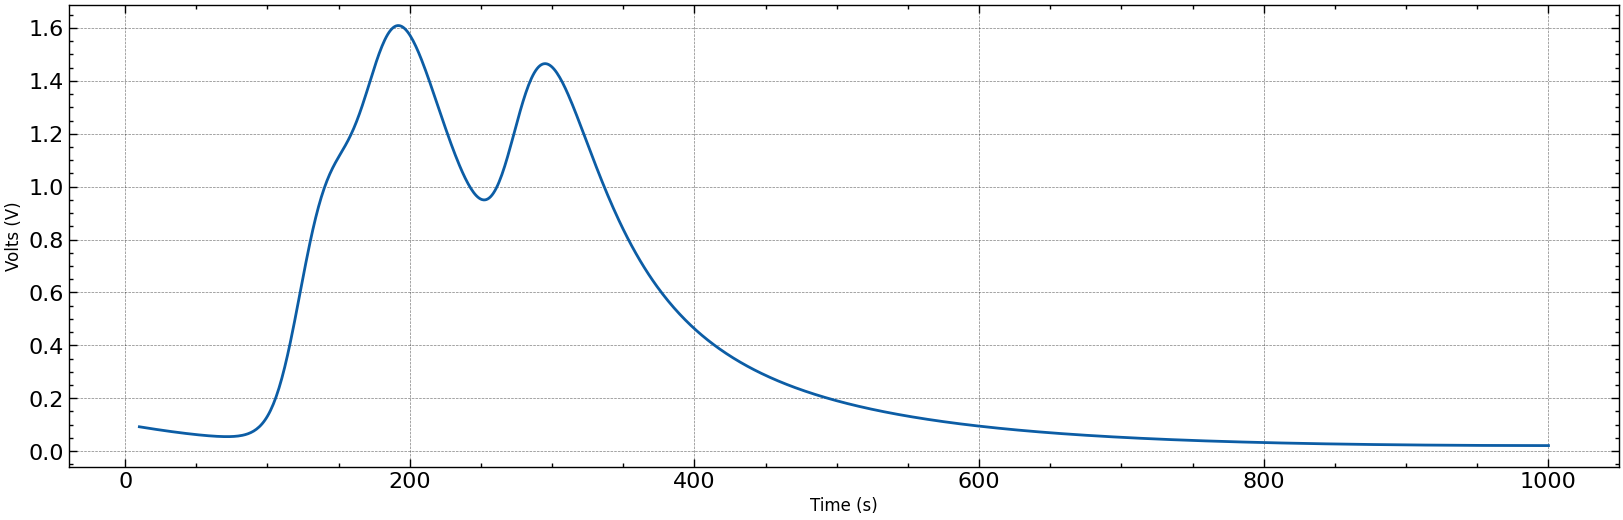

In [64]:
# fitInitGuess = [1,1, 400, 0.01, 1,3,4.5]

# fitBounds = ((0, 0, 0, 0.01, 0, 0, 0), (10, 15, 10000, 100, 5, 5, 5))

x = np.linspace(10, 1000, 1000)
# y = eit_lorentz(x, 5, 700, 500, 10)
y = three_eit_lorentz(x, 1, 5, 800, 100, 150, 200, 300)
# y = three_eit_lorentz(x, 1, 1, 700, 100, 1, 3, 4.5)

fig, ax = plt.subplots(figsize = (20,6), facecolor='w')

ax.plot(x, y, '-')

# ax.set_title('EIT Single Rail, Control 2.1 mW, Probe 46 uW, Rb @ 55 C') 
ax.set_xlabel('Time (s)', fontsize=12)
ax.set_ylabel('Volts (V)', fontsize=12)
ax.grid(True)

In [39]:
d2d1 =[]
d3d2 =[]

i = 0 
for num in nums:
    
    best_vals = np.load(eit_obj.npydir+f'/{num}_{current[i]}mA_{eit_obj.temp[:-2]}C_best_vals.npy')
#     print(best_vals[3])
    d1 = best_vals[4]
    d2 = best_vals[5]
    d3 = best_vals[6]
    print(best_vals[4],best_vals[5],best_vals[6])
    d2d1.append(best_vals[5]-best_vals[4])
    d3d2.append(best_vals[6]-best_vals[5])
#     print(type(best_vals[3]))
    i = i+1

2.516638516376333 2.412031146465867 2.5473042779190216
2.4410763274152227 2.4410582685865005 2.441064573065032
2.4538326753646578 2.453828084833705 2.453854570050392
2.5514906406915956 2.5514576731781347 2.55148195986238
2.237809089642351 2.427052724014254 2.6092795569515195
2.180038017752167 2.423509530809216 2.668705032466357
2.1222029076770026 2.4230208004623215 2.7261069470749173
2.070717464645178 2.4314158821486966 2.7992118260404095
2.0017918631067095 2.4174429017197583 2.8405742744215656
1.9429968767707901 2.4131279028619956 2.894013074381786
1.8912072214052515 2.4091664709228535 2.9402242856449488
1.8320151846285242 2.405208452955394 2.989364397019596
1.7025624177017669 2.4014219383107114 3.1155970281064316
1.6140023761876994 2.4040301021664856 3.2131300357855572
1.5025520152239824 2.399228249210463 3.3157619265103233
1.3908543627131569 2.3942989734121496 3.4187107716972367


In [46]:
len(d2d1), len(d3d2)

(16, 16)

In [41]:
d2d1 = [i*10**6 for i in d2d1] #convert MHz to Hz
d3d2 = [i*10**6 for i in d3d2]

In [43]:
d2d1 = [i/(2.803905*10**10) for i in d2d1] #convert Hz to T
d3d2 = [i/(2.803905*10**10) for i in d3d2]

In [45]:
d2d1 = [i*10**7 for i in d2d1] # convert T to mG
d3d2 = [i*10**7 for i in d3d2]

In [47]:
d3d2[15] 

365.35182122257606

In [65]:
current_theory = [0,4,10,20,30,60,80,100]

# gaussmeter probe position measurement with no cell
P1 = [60,80,100,120,140,240,280,350]
P2 = [30,70,90,100,130,250,310,380]
P3 = [60,70,60,90,120,250,300,380]
P4 = [80,100,140,160,180,300,350,350]
P5 = [40,70,90,140,150,270,320,400]
P6 = [10,40,70,90,150,230,320,360]

#Theoretical B = Mu*n*I

mu=constants.mu_0
mu_conversion = mu*10000 # (T*m/A) -> (G*m/A)
n=198
muN = mu_conversion*n
B = [muN*I for I in current_theory]
print(B)

I  = (10*(0.1297686))/(muN)

L = 0.1297686
B_L = [x/L for x in B]
B_L

[0.0, 9.9525655319904, 24.881413829976, 49.762827659952, 74.644241489928, 149.288482979856, 199.051310639808, 248.81413829976]


[0.0,
 76.69471298904665,
 191.73678247261662,
 383.47356494523325,
 575.2103474178499,
 1150.4206948356998,
 1533.894259780933,
 1917.3678247261662]

<class 'numpy.float64'> <class 'numpy.float64'> <class 'list'>
<class 'numpy.float64'> <class 'numpy.float64'> <class 'list'>


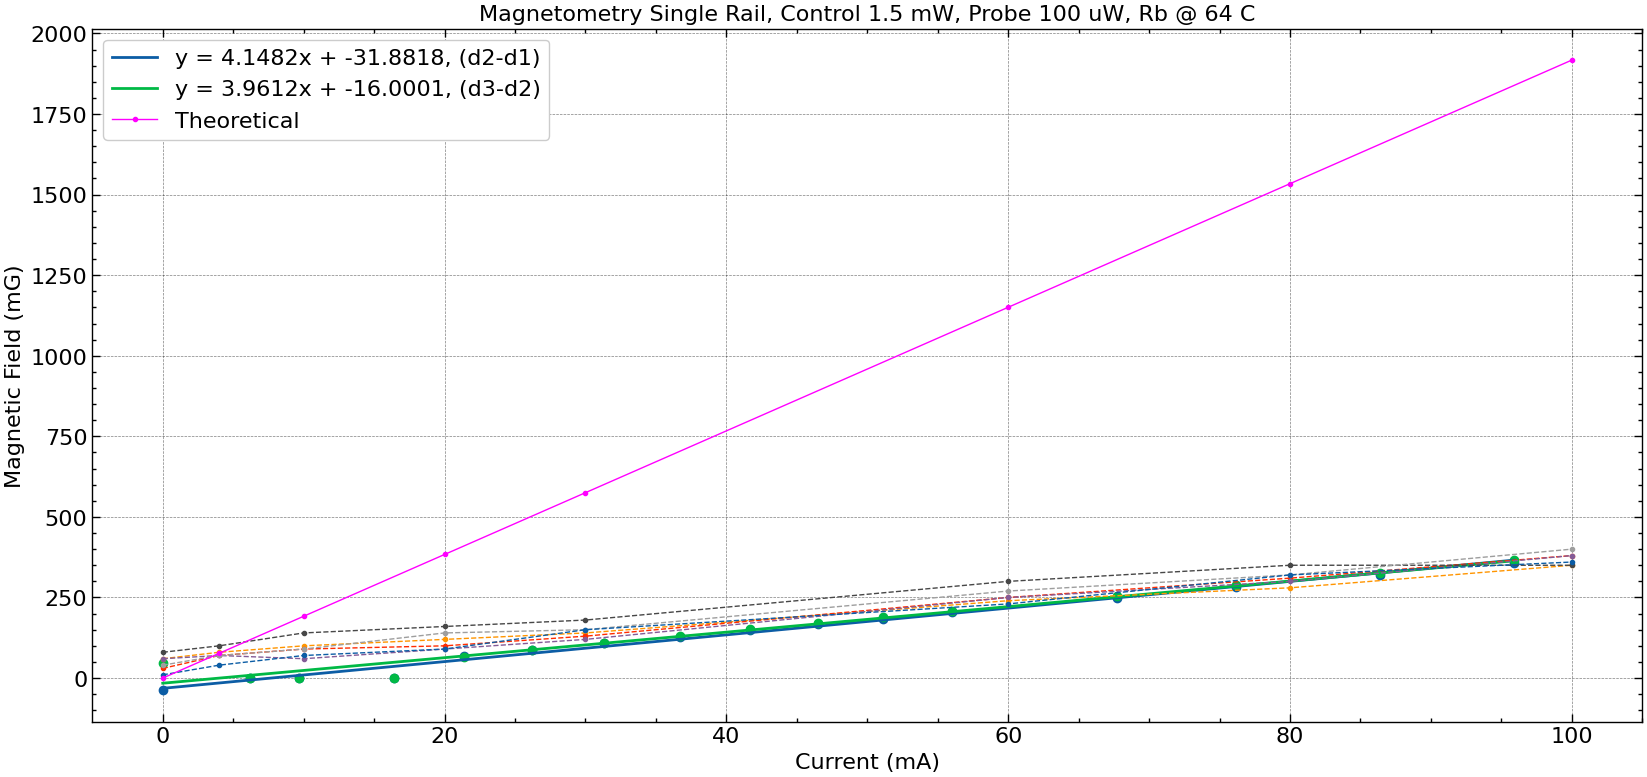

In [80]:
coefficients1 = np.polyfit(current, d2d1, 1)  # Fit a first-degree (linear) polynomial
coefficients2 = np.polyfit(current, d3d2, 1)  # Fit a first-degree (linear) polynomial


def predict(x, coefficients):
    slope, intercept = coefficients
    print(type(slope),type(intercept), type(x))
    return slope * np.array(x) + intercept

Y_pred1 = predict(current, coefficients1)
Y_pred2 = predict(current, coefficients2)
# print(type(Y_pred[0]), type(Y_pred[1]))

fig, ax = plt.subplots(figsize = (20,9), facecolor='w')
plt.scatter(current, d2d1)
plt.scatter(current, d3d2)
plt.plot(current, Y_pred1, label='y = %5.4fx + %5.4f, (d2-d1)' % tuple(coefficients1))
plt.plot(current, Y_pred2, label='y = %5.4fx + %5.4f, (d3-d2)' % tuple(coefficients2))

plt.plot(current_theory,P1, '.', linestyle='--', linewidth=1)
plt.plot(current_theory,P2, '.', linestyle='--', linewidth=1)
plt.plot(current_theory,P3, '.', linestyle='--', linewidth=1)
plt.plot(current_theory,P4, '.', linestyle='--', linewidth=1)
plt.plot(current_theory,P5, '.', linestyle='--', linewidth=1)
plt.plot(current_theory,P6, '.', linestyle='--', linewidth=1)
plt.plot(current_theory,B_L, '.', linestyle='-', linewidth=1,color='magenta', label='Theoretical')

plt.xlabel('Current (mA)', fontsize=16)
plt.ylabel('Magnetic Field (mG)', fontsize=16)
plt.title(f'Magnetometry Single Rail, Control 1.5 mW, Probe {eit_obj.probe_pwr}, Rb @ {eit_obj.temp}') 
ax.grid(True)
# plt.legend(["Pos. 1", "Pos. 2", "Pos. 3","Pos.4","Pos. 5","Pos. 6", "Theoretical"])
plt.legend(loc='best')
plt.savefig(root+'bfield_vs_current_with_theoretical.png')